# Klasifikasi Makanan Indonesia dengan Transfer Learning (VGG16)

Notebook ini bertujuan untuk membangun model Deep Learning yang dapat mengenali jenis makanan khas Indonesia.
Metode yang digunakan adalah **Transfer Learning** dengan model dasar **VGG16** yang telah dilatih sebelumnya pada dataset ImageNet. Pendekatan ini dipilih untuk mempercepat proses pelatihan dan meningkatkan akurasi meskipun dengan dataset yang terbatas.

## 1. Import Library
Memuat library utama yang dibutuhkan:
* **TensorFlow/Keras**: Framework utama untuk membangun model Deep Learning.
* **OpenCV (cv2)** & **OS**: Untuk manipulasi file gambar dan direktori.
* **Pandas & NumPy**: Untuk pengolahan data matriks/array.
* **Plotly**: Untuk visualisasi data interaktif.

In [ ]:
import zipfile
import os
import cv2
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Persiapan Dataset
Menghubungkan notebook dengan Google Drive untuk mengakses dataset. Pastikan file ZIP dataset makanan Indonesia sudah tersimpan di Drive kamu.

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Copy & Ekstrak Data
Menyalin file dataset dari Drive ke lingkungan lokal Colab (untuk akses baca-tulis yang lebih cepat) dan mengekstrak isinya.

In [ ]:
# 2. Copy file ZIP (Pastikan path ini benar sesuai drive Anda)
!cp "/content/drive/MyDrive/Dataset Indonesian Food/Indonesian Food 2.zip" "/content/sample_data"

In [ ]:
# 3. Unzip Data
print("Mengekstrak data...")
zip_ref = zipfile.ZipFile("/content/sample_data/Indonesian Food 2.zip", 'r')
zip_ref.extractall("/content/dataset_unzipped")
zip_ref.close()
print("Ekstraksi selesai.")

# 4. Definisi Path (Sesuaikan dengan struktur folder hasil unzip)
base_dir = "/content/dataset_unzipped/Clean_Data"
train_path = os.path.join(base_dir, "train")
test_path = os.path.join(base_dir, "test")
validation_path = os.path.join(base_dir, "test")
pred_path = os.path.join(base_dir, "pred")

Mengekstrak data...
Ekstraksi selesai.


## 3. Fungsi Helper: Memuat Gambar
Membuat fungsi khusus untuk membaca gambar dari folder direktori secara manual. Fungsi ini berguna jika kita ingin mengecek integritas data atau melakukan manipulasi spesifik sebelum masuk ke generator.

In [ ]:
# Function to load data
def load_data(path):
    categories = []
    images = []
    for category in os.listdir(path):
        category_path = os.path.join(path, category)
        for image in os.listdir(category_path):
            img_path = os.path.join(category_path, image)
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image is loaded correctly
                img = cv2.resize(img, (224, 224))  # Resize to 224x224 for VGG16
                images.append(img)
                categories.append(category)
    return np.array(images), np.array(categories)

# Load datasets
train_images, train_labels = load_data(train_path)
test_images, test_labels = load_data(test_path)
val_images, val_labels = load_data(validation_path)

## 4. Visualisasi Data
Menampilkan contoh salah satu gambar dari dataset pelatihan untuk memastikan data terbaca dengan benar. Kita menggunakan `Plotly` agar visualisasi lebih interaktif.

In [ ]:
# Plot sample images
fig = px.imshow(train_images[0])
fig.update_layout(title="Sample Image from Training Set")
fig.show()

## 5. Preprocessing & Augmentasi Data
Kita menggunakan `ImageDataGenerator` untuk:
1.  **Rescaling**: Mengubah nilai piksel menjadi rentang 0-1 (normalisasi).
2.  **Augmentasi**: Melakukan rotasi, geser, zoom, dan flip secara acak pada gambar training. Ini bertujuan untuk mencegah **Overfitting** dengan memperkaya variasi data latih.
3.  **Flow from Directory**: Memuat gambar secara otomatis dari folder berdasarkan nama kelasnya.

In [ ]:
# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224),
                                                    batch_size=32, class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_path, target_size=(224, 224),
                                                        batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_path, target_size=(224, 224),
                                                  batch_size=32, class_mode='categorical', shuffle=False)

Found 2866 images belonging to 10 classes.
Found 1163 images belonging to 10 classes.
Found 1163 images belonging to 10 classes.


## 6. Membangun Arsitektur Model (VGG16)
Kita menggunakan teknik **Transfer Learning**:
1.  **Base Model**: Menggunakan **VGG16** yang sudah dilatih dengan ImageNet sebagai ekstraktor fitur. Layer ini kita "bekukan" (`trainable = False`) agar bobot cerdasnya tidak rusak saat awal training.
2.  **Custom Head**: Menambahkan layer baru di bagian atas (Flatten, Dense, Dropout) yang spesifik untuk mengklasifikasikan jenis makanan Indonesia kita.

In [ ]:
# Load VGG16 model and fine-tune it
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

## 7. Melatih Model (Training Fase 1)
Melatih model dengan data generator. Pada tahap ini, hanya layer tambahan (Custom Head) yang belajar, sedangkan VGG16 tetap beku.

In [ ]:
# Model training
history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 79s 696ms/step - accuracy: 0.1973 - loss: 2.3771 - val_accuracy: 0.4557 - val_loss: 1.5833
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 526ms/step - accuracy: 0.3807 - loss: 1.7532 - val_accuracy: 0.5340 - val_loss: 1.3813
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 550ms/step - accuracy: 0.4232 - loss: 1.6154 - val_accuracy: 0.6165 - val_loss: 1.2236
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 57s 631ms/step - accuracy: 0.4936 - loss: 1.4824 - val_accuracy: 0.5924 - val_loss: 1.2201
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 626ms/step - accuracy: 0.5111 - loss: 1.4385 - val_accuracy: 0.6440 - val_loss: 1.0780
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 538ms/step - accuracy: 0.5566 - loss: 1.3458 - val_accuracy: 0.6483 - val_loss: 1.0576
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 551ms/step - accuracy: 0.5619 - loss: 1.2874 - val_accuracy: 0.6930 - val_loss: 1.0128
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 537ms/step - accuracy: 0.5714 - loss: 1.2791 - val_accu

## 8. Fine-Tuning (Penyetelan Halus)
Untuk meningkatkan akurasi, kita "mencairkan" sebagian layer atas dari VGG16 (`base_model.trainable = True`).
* Kita membiarkan 15 layer pertama tetap beku (bekerja sebagai pendeteksi fitur dasar seperti garis/tepi).
* Layer sisanya dilatih ulang dengan *learning rate* yang sangat kecil (`1e-5`) agar model lebih adaptif terhadap detail makanan Indonesia.

In [ ]:
# Unfreeze some layers in the base model and fine-tune
base_model.trainable = True
for layer in base_model.layers[:15]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 605ms/step - accuracy: 0.7111 - loss: 0.8677 - val_accuracy: 0.7532 - val_loss: 0.7494
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 524ms/step - accuracy: 0.7528 - loss: 0.7524 - val_accuracy: 0.7610 - val_loss: 0.7201
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 520ms/step - accuracy: 0.7526 - loss: 0.7454 - val_accuracy: 0.7567 - val_loss: 0.7585
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 524ms/step - accuracy: 0.7811 - loss: 0.6651 - val_accuracy: 0.7730 - val_loss: 0.7282
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 520ms/step - accuracy: 0.7731 - loss: 0.6580 - val_accuracy: 0.7842 - val_loss: 0.7249
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 525ms/step - accuracy: 0.7984 - loss: 0.6392 - val_accuracy: 0.7782 - val_loss: 0.6826
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 523ms/step - accuracy: 0.8128 - loss: 0.5687 - val_accuracy: 0.7893 - val_loss: 0.6762
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 531ms/step - accuracy: 0.8157 - loss: 0.5408 - val_accu

## 9. Evaluasi Model
Menguji performa model menggunakan **Data Test** yang belum pernah dilihat model sebelumnya. Ini memberikan gambaran akurasi model di dunia nyata.

In [ ]:
# Model evaluation
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.8176 - loss: 0.6073
Test Accuracy: 83.06%


## 10. Classification Report
Menampilkan metrik detail seperti **Precision**, **Recall**, dan **F1-Score** untuk setiap jenis makanan. Ini membantu kita melihat makanan apa yang paling mudah atau paling sulit dikenali oleh model.

In [ ]:
# Classification report and confusion matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

# Create confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Plot confusion matrix with annotations
cm_fig = px.imshow(cm, labels=dict(x="Predicted", y="True", color="Count"), x=list(test_generator.class_indices.keys()), y=list(test_generator.class_indices.keys()), text_auto=True)
cm_fig.update_layout(title="Confusion Matrix")
cm_fig.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step
Classification Report
              precision    recall  f1-score   support

       bakso       0.92      0.79      0.85       127
bebek_betutu       0.86      0.66      0.75        94
   gado_gado       0.77      0.95      0.85       110
       gudeg       0.74      0.72      0.73        79
 nasi_goreng       0.88      0.89      0.88       152
      pempek       0.90      0.86      0.88       120
       rawon       0.70      0.89      0.78       101
     rendang       0.75      0.77      0.76        91
        sate       0.95      0.88      0.91       151
        soto       0.81      0.81      0.81       138

    accuracy                           0.83      1163
   macro avg       0.83      0.82      0.82      1163
weighted avg       0.84      0.83      0.83      1163



## 11. Grafik Training History
Visualisasi grafik pergerakan **Akurasi** dan **Loss** selama proses training.
* Jika garis *Training* terus naik tapi *Validation* datar/turun, tandanya terjadi **Overfitting**.
* Model yang baik memiliki garis Train dan Validation yang berdekatan dan menanjak bersama.

In [ ]:
# Plot training history
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['accuracy'], mode='lines', name='Train Accuracy'))
fig.add_trace(go.Scatter(y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis=dict(title='Epoch'), yaxis=dict(title='Accuracy'))
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(title='Model Loss', xaxis=dict(title='Epoch'), yaxis=dict(title='Loss'))
fig.show()

fig_fine = go.Figure()
fig_fine.add_trace(go.Scatter(y=history_fine.history['accuracy'], mode='lines', name='Fine-tune Train Accuracy'))
fig_fine.add_trace(go.Scatter(y=history_fine.history['val_accuracy'], mode='lines', name='Fine-tune Validation Accuracy'))
fig_fine.update_layout(title='Fine-tuning Model Accuracy', xaxis=dict(title='Epoch'), yaxis=dict(title='Accuracy'))
fig_fine.show()

fig_fine_loss = go.Figure()
fig_fine_loss.add_trace(go.Scatter(y=history_fine.history['loss'], mode='lines', name='Fine-tune Train Loss'))
fig_fine_loss.add_trace(go.Scatter(y=history_fine.history['val_loss'], mode='lines', name='Fine-tune Validation Loss'))
fig_fine_loss.update_layout(title='Fine-tuning Model Loss', xaxis=dict(title='Epoch'), yaxis=dict(title='Loss'))
fig_fine_loss.show()

## 12. Uji Coba Prediksi Gambar
Bagian ini memungkinkan kita mengupload gambar makanan dari internet/lokal untuk ditebak oleh model. Kode ini akan memproses gambar input, mengubah ukurannya menjadi 224x224, dan mengeluarkan prediksi jenis makanannya.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


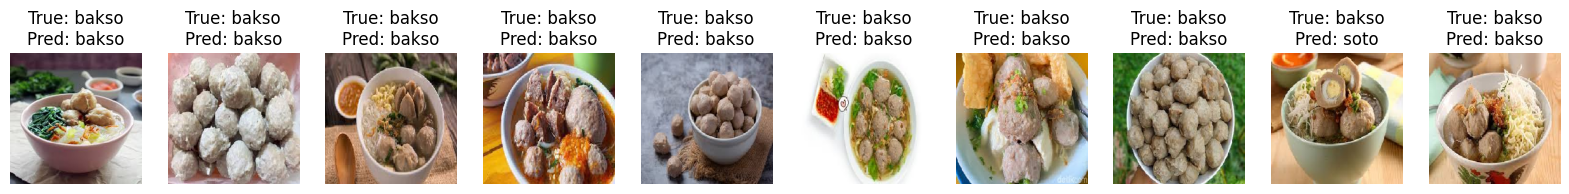

In [ ]:
# Display some predictions
def display_predictions(generator, model, num_images=10):
    images, labels = next(generator)
    predictions = model.predict(images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i])
        true_label = list(generator.class_indices.keys())[np.argmax(labels[i])]
        pred_label = list(generator.class_indices.keys())[np.argmax(predictions[i])]
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')
    plt.show()

display_predictions(test_generator, model)

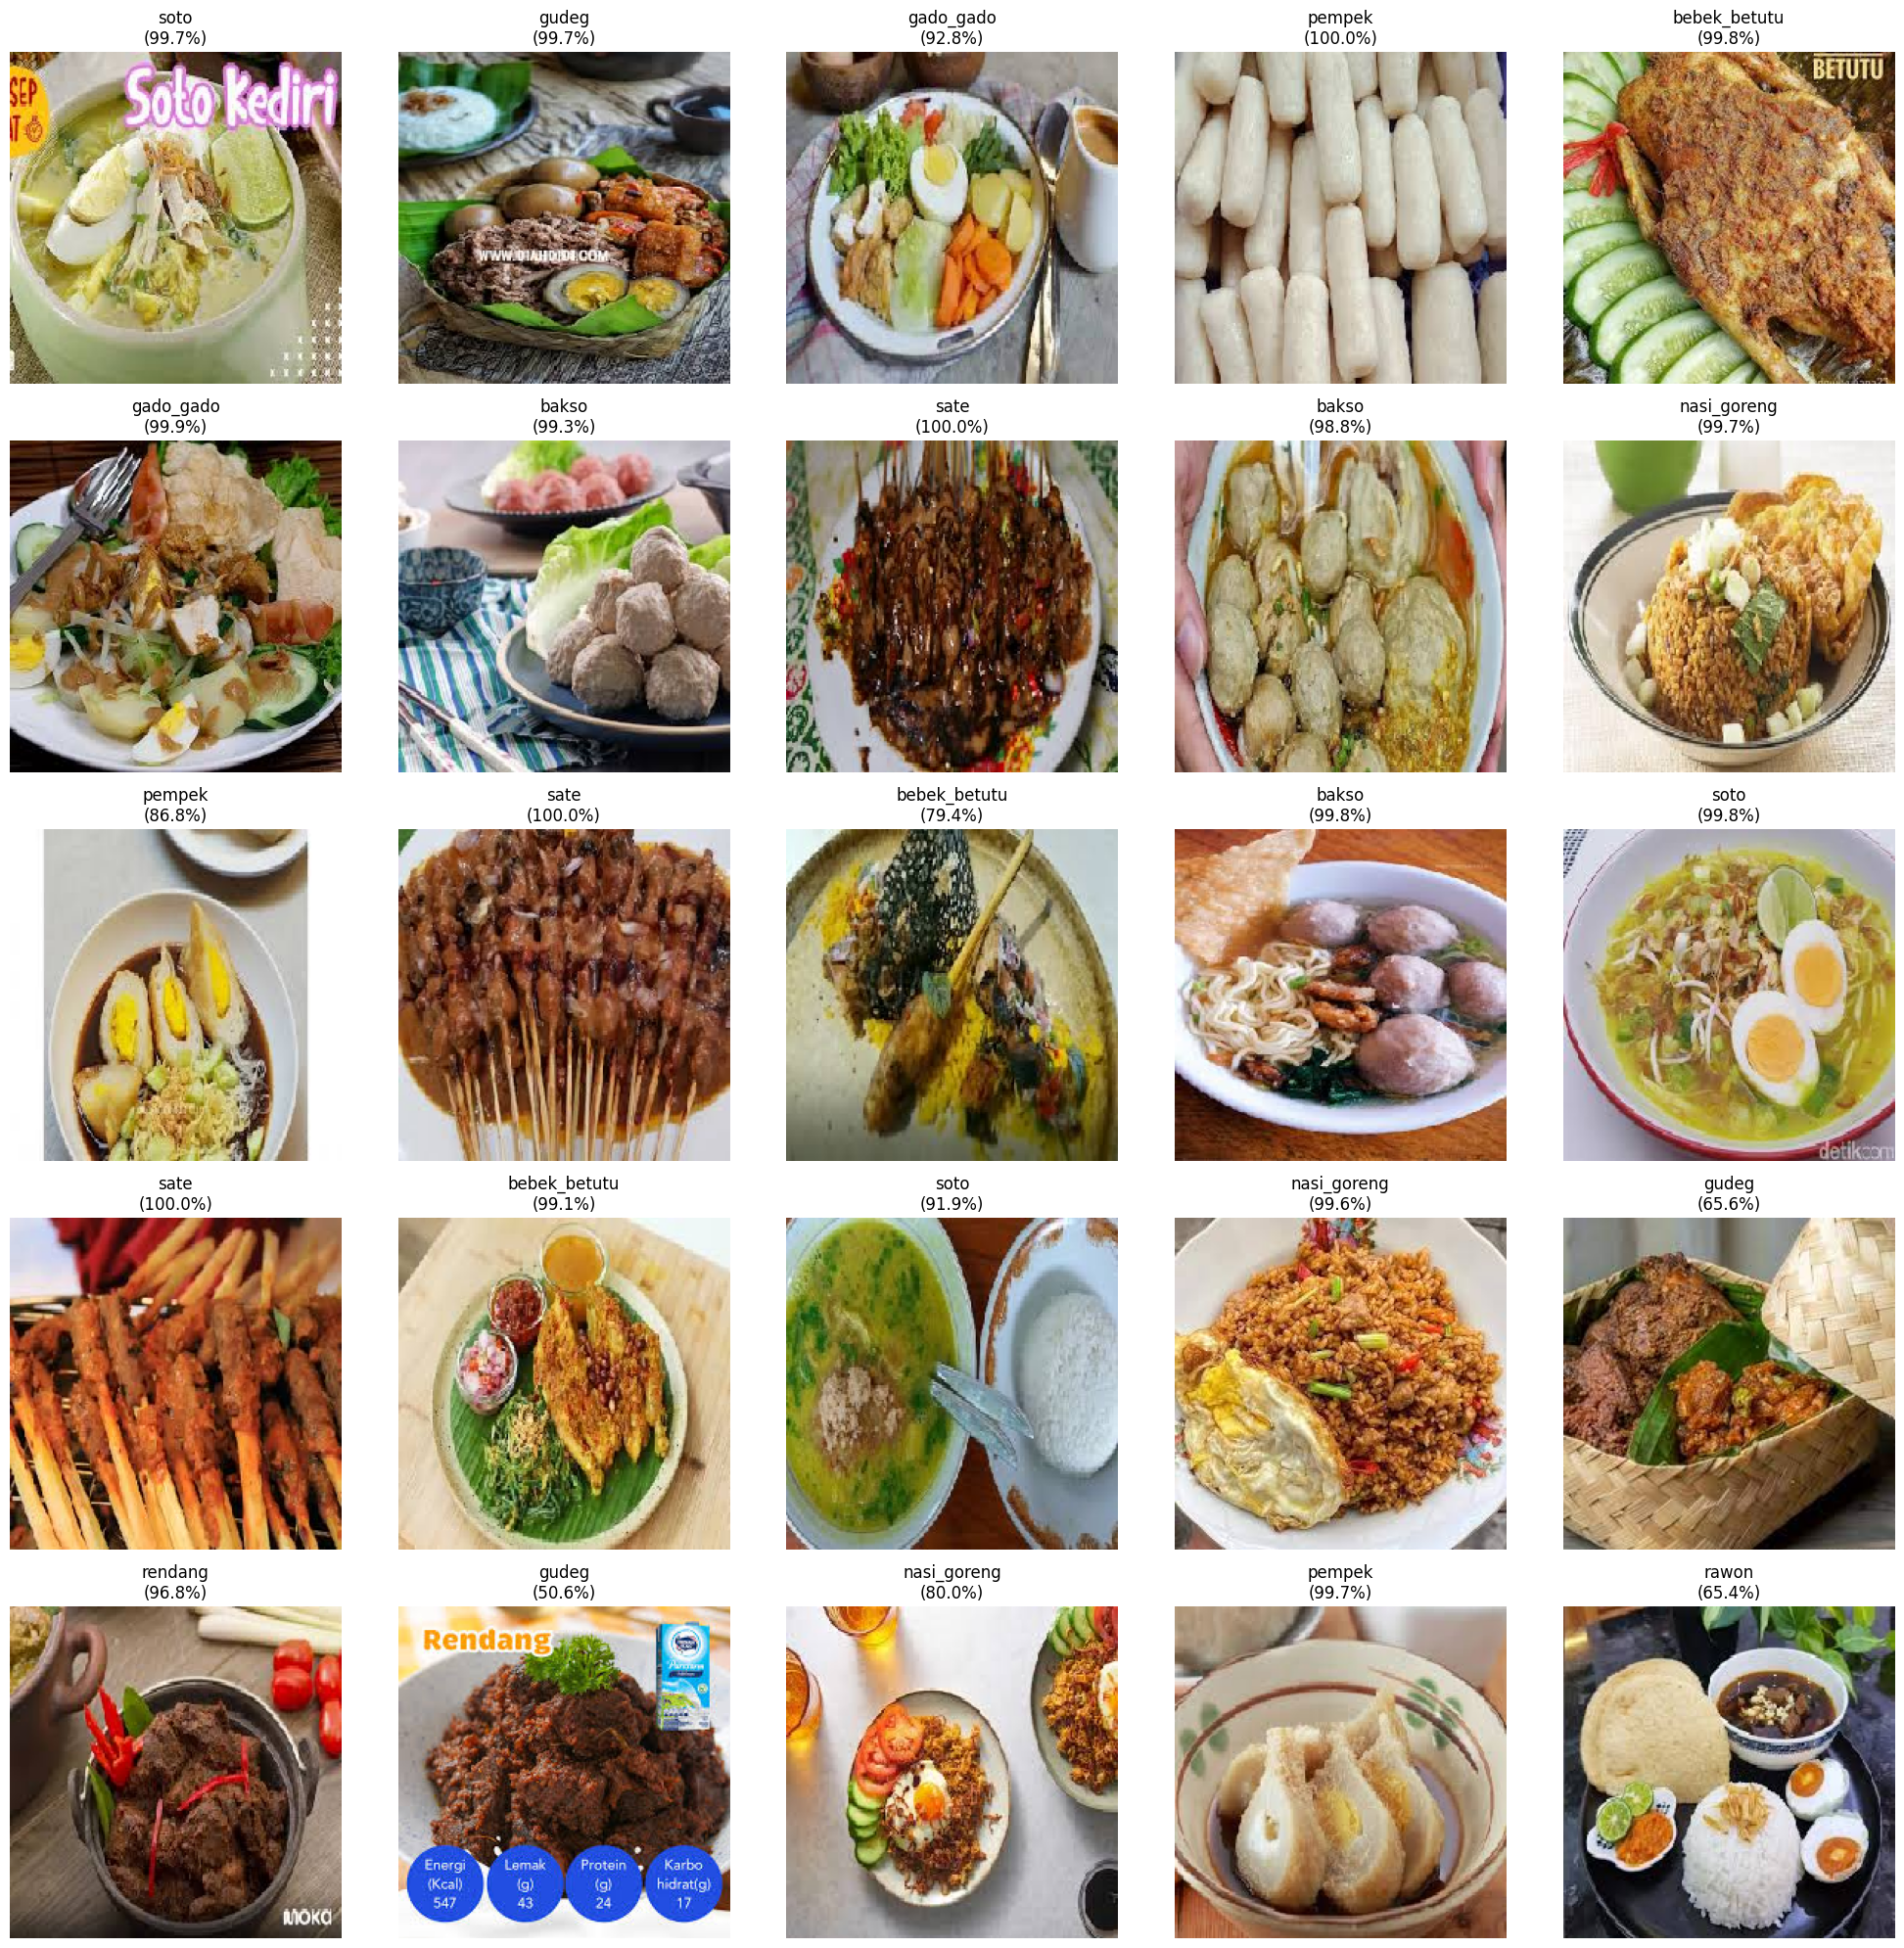

In [ ]:
from tensorflow.keras.preprocessing import image

# 1. Ambil daftar nama kelas dari generator yang sudah dibuat sebelumnya
# Kunci dictionary adalah nama kelas (misal: 'bakso', 'rendang')
class_names = list(train_generator.class_indices.keys())

# 2. Ambil file gambar dari folder prediksi
pred_files = [os.path.join(pred_path, f) for f in os.listdir(pred_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# 3. Lakukan Loop, Prediksi, dan Plotting
plt.figure(figsize=(20, 20))

for i, img_path in enumerate(pred_files):
    # Batasi hanya menampilkan 25 gambar pertama
    if i > 24: break

    try:
        # --- Preprocessing Gambar ---
        # Load gambar dan resize ke ukuran input model (224, 224)
        img = image.load_img(img_path, target_size=(224, 224))

        # Ubah gambar menjadi array numpy
        x = image.img_to_array(img)

        # Normalisasi (Sangat Penting: harus sama dengan rescale=1./255 saat training)
        x = x / 255.0

        # Tambahkan dimensi batch (karena model mengharapkan input [batch, height, width, channels])
        # Menjadi (1, 224, 224, 3)
        x = np.expand_dims(x, axis=0)

        # --- Prediksi ---
        # verbose=0 agar tidak keluar loading bar untuk setiap gambar
        predictions = model.predict(x, verbose=0)

        # Ambil index dengan probabilitas tertinggi
        predicted_index = np.argmax(predictions)
        predicted_label = class_names[predicted_index]
        confidence = np.max(predictions) * 100 # Persentase keyakinan

        # --- Visualisasi ---
        plt.subplot(5, 5, i + 1)
        plt.imshow(img) # Tampilkan gambar asli
        # Tampilkan nama prediksi dan tingkat keyakinan
        plt.title(f"{predicted_label}\n({confidence:.1f}%)")
        plt.axis('off')

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

plt.tight_layout()
plt.show()